In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 4090


In [2]:
#%% import

import os
import collections
from collections import defaultdict
import io
import itertools
import numpy as np
import numpy.random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.interpolate 
import scipy.signal
from scipy import linalg
from sklearn.linear_model import PoissonRegressor
from tqdm import tqdm
import sys
import copy
from numpy.fft import fft as fft
from numpy.fft import ifft as ifft
import scipy.stats
import copy
from scipy.special import rel_entr
import pickle
from sklearn.model_selection import KFold
from scipy.stats import wilcoxon, chi2

import statsmodels.api as sm
import statsmodels.genmod.generalized_linear_model as smm

import utility_functions as utils

import torch
from torch.autograd import Variable
from torch.nn import functional as F

# Decoder

When the encoder and the simulus effects are fixed, this decoder would give the posterior of graphical latents very quickly (optimized using Newton's method). 

In [3]:
def get_K(sigma2=1.0, L=100.0, nt=500):
    """
    Get the covariance matrix K for GPFA.

    Parameters:
    - sigma2 (float): The variance of the Gaussian kernel.
    - L (float): The length scale of the Gaussian kernel.
    - n (int): The number of time bins.

    Returns:
    - K (ndarray): The covariance matrix. Shape: (n, n).
    """
    x = np.linspace(0, nt-1, nt)
    diff = np.subtract.outer(x, x)
    K = sigma2 * np.exp(-diff**2 / L**2)
    return K


In [4]:
def make_4d_diagonal(mat):
    """
    Take a matrix of shape (n, m, l) and return a 3D array of shape (n, m, l, l) where
    the original matrix is repeated along the last axis.
    """
    # Initialize an empty 3D array with the required shape
    mat_diag = np.zeros((mat.shape[0], mat.shape[1], mat.shape[2], mat.shape[2]))

    # Use advanced indexing to fill in the diagonals
    i = np.arange(mat.shape[2])
    mat_diag[:, :, i, i] = mat

    return mat_diag

# mat = np.random.rand(2, 3, 4)  # Example input matrix of shape (2, 3, 4)
# mat_4d_diag = make_4d_diagonal(mat)

# print(mat[0,0,:])
# mat_4d_diag[0,0,:,:]

In [5]:
K = get_K(nt=100, L=20)
np.linalg.inv(K)

array([[ 3.84595425e+12,  4.04330090e+12, -7.88592782e+13, ...,
        -7.14790809e+14,  1.57872657e+14, -1.21594133e+13],
       [-5.34488102e+13,  1.65319406e+14,  6.59665757e+13, ...,
         3.69547096e+15, -8.79806192e+14,  7.80756065e+13],
       [ 2.03830535e+14, -9.32807803e+14,  1.20783638e+15, ...,
        -5.15202531e+15,  1.45263665e+15, -1.59676223e+14],
       ...,
       [-2.10609024e+13,  1.30079482e+14, -2.87635507e+14, ...,
        -3.87585331e+15,  1.32029513e+15, -1.69949382e+14],
       [ 2.86346843e+13, -1.46516017e+14,  2.41646687e+14, ...,
         2.13856847e+15, -6.80735408e+14,  8.03056808e+13],
       [-7.18048916e+12,  3.55558972e+13, -5.47539906e+13, ...,
        -4.20416995e+14,  1.25844129e+14, -1.36060426e+13]])

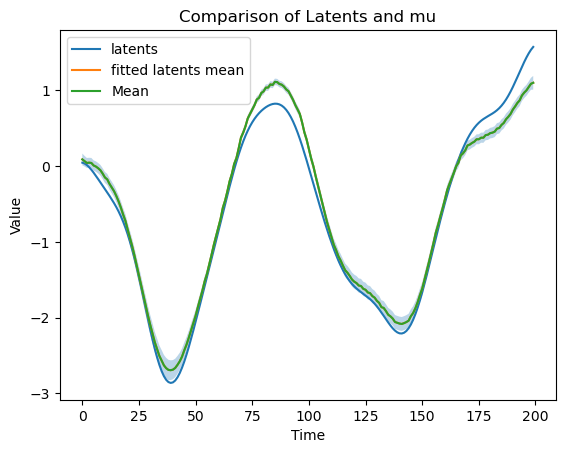

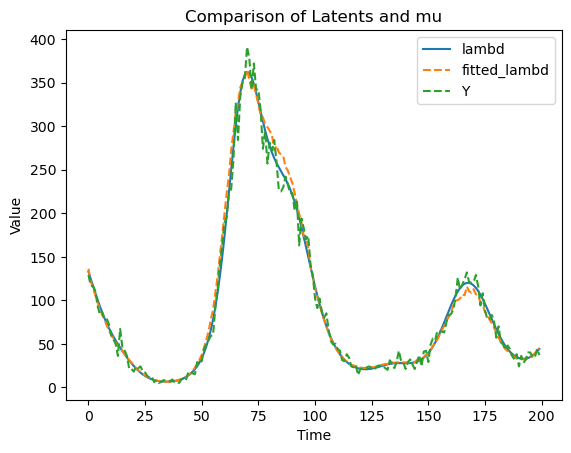

In [6]:
import numpy as np
def gpfa_poisson_fix_weights(Y, 
                             weights,
                             K,
                             bias=None, 
                             max_iter=10, 
                             tol=1e-2, 
                             verbose=False):
    """
    Perform Gaussian Process Factor Analysis (GPFA) with fixed weights for Poisson data.

    Parameters:
    - Y (ndarray): The observed spike counts. Shape: (ntrial, nneuron, nt).
    - weights (ndarray): The fixed weights matrix. Shape: (nneuron, nlatent).

    Returns:
    - mu (ndarray): The estimated latent variables. Shape: (ntrial, nlatent, nt).
    """
    
    # Get dimensions
    if Y.ndim == 2:
        Y = Y[np.newaxis, :, :]
    ntrial, nneuron, nt = Y.shape
    nlatent = weights.shape[1]

    # Initialize latents with all zeros
    # mu = np.zeros((ntrial, nlatent, nt))
    # mu = np.ones((ntrial, nlatent, nt))
    mu = np.random.rand(ntrial, nlatent, nt)
    
    # K = get_K(nt=nt, L=50)
    inv_K = np.linalg.inv(K+1e-3*np.eye(nt))
    if bias is None:
        bias = 4
    loss_old = -np.inf

    for i in range(max_iter):
        
        log_lambd = weights@mu + bias
        lambd = np.exp(log_lambd)
        loss = np.sum(Y*log_lambd - lambd)
        if verbose:
            print(f'Loss changed  {loss-loss_old}')
        if i>=10 and loss-loss_old < 1e-3:
            print(f'Converged at iteration {i} with loss {loss}')
            break
        grad = weights.T@(Y-lambd) - mu@inv_K
        hessian = -inv_K[np.newaxis, np.newaxis, :, :] - make_4d_diagonal(((weights**2).T)@lambd)
        # eigenvalues = np.linalg.eigvalsh(hessian)
        # assert np.all(eigenvalues <= 0.1)

        # mu_new = mu + 1e-3*grad
        mu_new = mu - 1e-1*np.linalg.solve(hessian, grad)
        
        loss_old = loss
        # Check convergence
        if np.linalg.norm(mu-mu_new) < tol:
            print(f'Converged at iteration {i} with loss {loss}')
            break
        mu = mu_new
        
    return mu_new, np.linalg.inv(hessian), lambd

# Parameters for data generation
ntrial = 1  # Number of trials
nt = 200    # Number of time bins
nneuron = 10 # Number of neurons
nlatent = 4 # Number of latent variables

# Generate covariance matrix K for the latent variables
K = get_K(nt=nt, L=20)

# Generate latent variables from a multivariate normal distribution
np.random.seed(0)
latents = np.random.multivariate_normal(np.zeros(nt), K, (ntrial, nlatent))
# latents = np.swapaxes(latents, 1, 2)

# Known weights matrix
np.random.seed(3)
weights = np.abs(np.random.rand(nneuron, nlatent))

# Generate observed spike counts Y
# Calculate the mean of the Poisson distribution
lambd = np.exp(weights@latents+4)
# Sample Y from Poisson distribution
Y = np.random.poisson(lambd)

# Now Y, weights, and K can be used to test the gpfa_poisson_fix_weights function
mu, cov, fitted_lambd = gpfa_poisson_fix_weights(Y, weights, K, max_iter=100, verbose=False)


plt.figure()
plt.plot(latents[0, 0, :], label='latents')
plt.plot(mu[0, 0, :], label='fitted latents mean')

std = np.sqrt(np.diagonal(-cov, axis1=-2, axis2=-1))
lower_bound = mu - 1.96 * std
upper_bound = mu + 1.96 * std
plt.plot(mu[0, 0, :], label='Mean')
plt.fill_between(range(nt), lower_bound[0, 0, :], upper_bound[0, 0, :], alpha=0.3)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Comparison of Latents and mu')
plt.legend()
plt.show()

plt.figure()
plt.plot(lambd[0, 0, :], label='lambd')
plt.plot(fitted_lambd[0, 0, :], '--', label='fitted_lambd')
plt.plot(Y[0, 0, :]+0.1, '--', label='Y')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Comparison of Latents and mu')
plt.legend()
plt.show()

In [33]:
import numpy as np

def incomplete_cholesky(K, eta):
    """
    Incomplete Cholesky factorization according to the algorithm provided.
    
    Args:
    K (numpy.ndarray): An N x N semidefinite positive matrix.
    eta (float): Precision parameter.
    
    Returns:
    P (numpy.ndarray): Permutation matrix.
    G (numpy.ndarray): Lower triangular matrix.
    M (int): The rank of G.
    """
    N = K.shape[0]
    P = np.eye(N)  # Initialize permutation matrix as the identity matrix
    K_prime = K.copy()
    G = np.zeros_like(K_prime)  # Initialize G with zeros
    np.fill_diagonal(G, K_prime.diagonal())  # Set diagonal elements of G
    
    i = 0
    while np.sum(np.diag(G)[i:]**2) > eta:
        # Find best new element
        j_star = np.argmax(K_prime.diagonal()[i:])
        j_star += i  # Adjust index since argmax is relative to subarray starting at i

        # Update permutation P
        P[i, i] = 0
        P[j_star, j_star] = 0
        P[i, j_star] = 1
        P[j_star, i] = 1
        K_prime[[i, j_star], :] = K_prime[[j_star, i], :]  # Swap rows
        K_prime[:, [i, j_star]] = K_prime[:, [j_star, i]]  # Swap columns
        
        # Update G due to new permutation
        G[[i,j_star], :i+1] = G[[j_star,i], :i+1]
        
        # Set Gii
        G[i, i] = np.sqrt(K_prime[i, i])
        
        # Calculate i-th column of G
        G[i+1:, i] = (K_prime[i+1:, i] - (G[i+1:, :i]@(G[i, :i][:,np.newaxis])).flatten()) / G[i, i]
        
        # Update only diagonal elements
        for j in range(i+1, N):
            G[j, j] = K_prime[j, j] - np.sum(G[j, :i+1]**2)
        
        i += 1  # Increment index

        # if i>=4:
        #     break
    r = i - 1  # Rank of G
    return P, G[:,:i-1], r


K = get_K(nt=5, L=3)
eta = 1e-1  # Precision parameter
P, G, r = incomplete_cholesky(K, eta)
print("Permutation matrix P:", P)
print("Lower triangular matrix G:", G)
print(K)
print(G@G.T)


Permutation matrix P: [[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
Lower triangular matrix G: [[1.00049988 0.         0.         0.        ]
 [0.89439223 1.00049988 0.         0.        ]
 [0.64086004 0.32149837 1.00049988 0.        ]
 [0.36769564 0.31216022 0.55855966 1.00049988]
 [0.16892887 0.21668246 0.46302611 0.50620451]]
[[1.001      0.89483932 0.64118039 0.36787944 0.16901332]
 [0.89483932 1.001      0.89483932 0.64118039 0.36787944]
 [0.64118039 0.89483932 1.001      0.89483932 0.64118039]
 [0.36787944 0.64118039 0.89483932 1.001      0.89483932]
 [0.16901332 0.36787944 0.64118039 0.89483932 1.001     ]]
[[1.001      0.89483932 0.64118039 0.36787944 0.16901332]
 [0.89483932 1.80093747 0.89483932 0.64118039 0.36787944]
 [0.64118039 0.89483932 1.51506279 0.89483932 0.64118039]
 [0.36787944 0.64118039 0.89483932 1.54563299 0.89483932]
 [0.16901332 0.36787944 0.64118039 0.89483932 0.54612444]]


# Encoder

When at a point in the parameter space of the encoder, the decoder first generate the variational posterior, then taking the posterior as fixed values, perform gradient descent with regard to the encoder parameters, taking ELBO as the objective function. 